In [1]:
# Basics
import numpy as np
import pandas as pd

In [2]:
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# sns.set_theme(style="darkgrid")

In [3]:
# ML
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import robust_scale
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR

# Classification
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV

from umap import UMAP

random_state = 42

### Load data


In [4]:
wine = pd.read_csv("winequality-red.csv")

wine_X = wine.loc[:, "fixed acidity":"alcohol"]
wine_y = wine.quality

X_train, X_test, y_train, y_test = train_test_split(
    wine_X, wine_y, random_state=random_state, stratify=wine_y
)

## EDA


<AxesSubplot:xlabel='quality', ylabel='Count'>

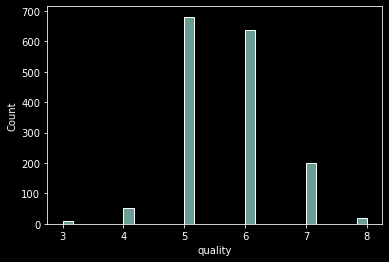

In [5]:
sns.histplot(
    data=wine_y,
)

C:\tools\miniconda3\lib\site-packages\seaborn\matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


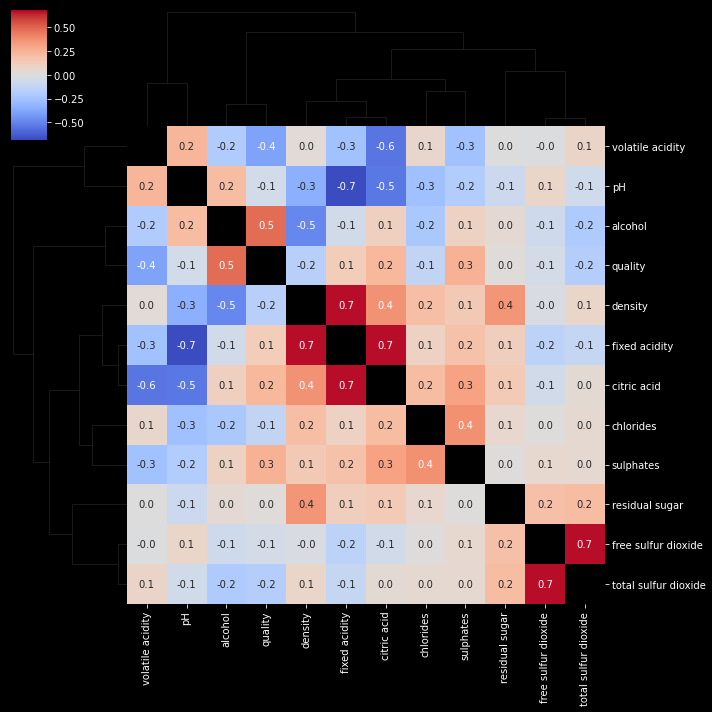

In [6]:
mask = np.identity(12)
sns.clustermap(
    # pd.DataFrame(robust_scale(wine)).corr(),
    wine.corr(method="pearson"),
    metric="cosine",
    annot=True,
    mask=mask,
    fmt="1.1f",
    square=True,
    # z_score=1,
    cmap="coolwarm",
    norm=colors.CenteredNorm(),
)

<AxesSubplot:>

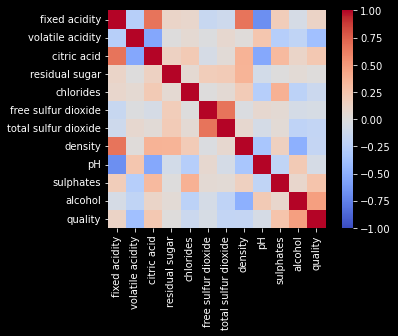

In [7]:
sns.heatmap(
    wine.corr(),
    square=True,
    # annot=True,
    fmt=".1f",
    cmap="coolwarm",
    norm=colors.CenteredNorm(),
)

## Train ML Models

### Regressors


In [8]:
estimators = [
    (
        "knnr",
        KNeighborsRegressor(
            weights="distance",
            n_neighbors=100,
        ),
    ),
    (
        "gpr",
        GaussianProcessRegressor(
            n_restarts_optimizer=10, normalize_y=True, random_state=random_state
        ),
    ),
    ("rfr", RandomForestRegressor(random_state=random_state, n_jobs=-1)),
    ("SVR", LinearSVR(max_iter=100000, random_state=random_state)),
]

scaler = RobustScaler()

In [9]:
for i in estimators:
    pipeline = make_pipeline(scaler, i[1])
    pipeline.fit(X=X_train, y=y_train)
    pred = pipeline.predict(X=X_test)

    print(
        "Estimator: "
        f"{i[0]} \n"
        "Score: "
        f"{pipeline.score(X_test, y_test):.2} \n"
        "MSE: "
        f"{mean_squared_error(y_test, pred):.2} \n"
    )

Estimator: knnr 
Score: 0.45 
MSE: 0.36 

Estimator: gpr 
Score: 0.14 
MSE: 0.56 

Estimator: rfr 
Score: 0.48 
MSE: 0.34 

Estimator: SVR 
Score: 0.36 
MSE: 0.41 



In [10]:
reg_comp = StackingRegressor(
    estimators=estimators,
    n_jobs=-1,
)

pipeline = make_pipeline(scaler, reg_comp)

pipeline.fit(X=X_train, y=y_train)
pred = pipeline.predict(X=X_test)

print("Score: " f"{pipeline.score(X_test, y_test):.2}")
print("MSE: " f"{mean_squared_error(y_test, pred):.2}")

Score: 0.52
MSE: 0.31


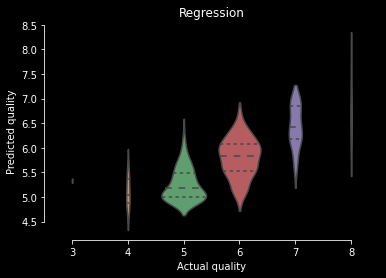

In [11]:
sns.violinplot(
    x=y_test,
    y=pred,
    palette="deep",
    cut=1,
    inner="quartile",
    scale="count",
)

plt.title("Regression")
plt.xlabel("Actual quality")
plt.ylabel("Predicted quality")
sns.despine(trim=True)

### Classifiers


In [70]:
estimators = [
    ("knnc", KNeighborsClassifier(weights="distance", n_neighbors=50, n_jobs=-1)),
    ("gpc", GaussianProcessClassifier(random_state=random_state, warm_start=True)),
    (
        "rfc",
        RandomForestClassifier(
            random_state=random_state, class_weight="balanced_subsample", n_jobs=-1
        ),
    ),
    ("SVC", LinearSVC(max_iter=100000, random_state=random_state)),
]

final_estimator = LogisticRegressionCV(
    max_iter=1000,
    # solver="liblinear"
)

scaler = RobustScaler(unit_variance=True)

In [71]:
for i in estimators:
    pipeline = make_pipeline(scaler, i[1])
    pipeline.fit(X=X_train, y=y_train)
    pred = pipeline.predict(X=X_test)

    print(
        "Estimator: "
        f"{i[0]} \n"
        "Score: "
        f"{pipeline.score(X_test, y_test):.2} \n"
        "MSE: "
        f"{mean_squared_error(y_test, pred):.2} \n"
    )

Estimator: knnc 
Score: 0.69 
MSE: 0.4 

Estimator: gpc 
Score: 0.66 
MSE: 0.52 

Estimator: rfc 
Score: 0.68 
MSE: 0.39 

Estimator: SVC 
Score: 0.58 
MSE: 0.52 



In [106]:
reducer = UMAP(
    n_neighbors=40,
    n_components=10,
    min_dist=0,
    metric="correlation",
    unique=True,
    # target_metric="l1",
    target_weight=0.4,
)

pipe_umap = make_pipeline(scaler, reducer)

pipe_umap.fit(X=X_train, y=y_train)

Pipeline(steps=[('robustscaler', RobustScaler(unit_variance=True)),
                ('umap',
                 UMAP(angular_rp_forest=True, metric='correlation', min_dist=0, n_components=10, n_neighbors=40, target_weight=0.4, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}, unique=True))])

In [116]:
class_comp = StackingClassifier(
    estimators=estimators,
    # final_estimator=final_estimator,
    n_jobs=-1,
    verbose=0,
)

pipeline = make_pipeline(
    scaler,
    # reducer,
    class_comp,
)

pipeline.fit(X=X_train, y=y_train)
pred = pipeline.predict(X=X_test)

print(
    "Stacking Classifier \n"
    "Score: "
    f"{pipeline.score(X_test, y_test):.2} \n"
    "MSE: "
    f"{mean_squared_error(y_test, pred):.2}"
)

C:\tools\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking Classifier 
Score: 0.7 
MSE: 0.38


In [117]:
proba = pipeline.predict_proba(X_test)
entropy = -np.sum(np.log2(proba) * proba, axis=1)

In [ ]:
sns.histplot(entropy)

In [118]:
plt.figure(figsize=(7, 7))

sns.scatterplot(
    x=pipeline["umap"].embedding_[:, 0],
    y=pipeline["umap"].embedding_[:, 1],
    hue=y_train,
    palette="Set1",
    s=4,
)

KeyError: 'umap'

<Figure size 504x504 with 0 Axes>

<AxesSubplot:>

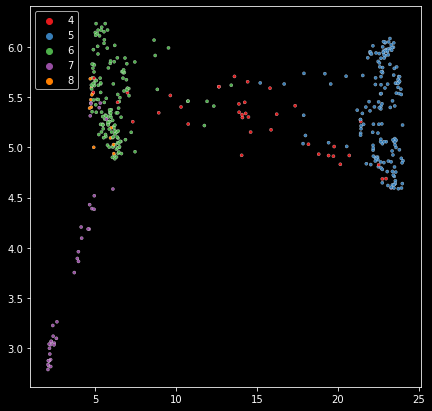

In [ ]:
plt.figure(figsize=(7, 7))
sns.scatterplot(
    x=pipeline[:2].transform(X=X_test)[:, 0],
    y=pipeline[:2].transform(X=X_test)[:, 1],
    hue=pred,
    palette="Set1",
    # hue=entropy,
    # size=proba,
    # sizes=(5,15),
    s=10,
)

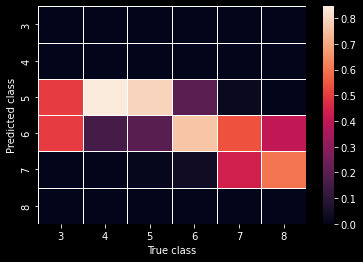

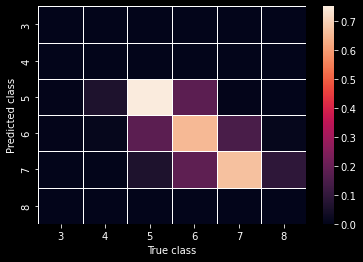

MCC for classification: 0.51


In [171]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix

sns.heatmap(
    confusion_matrix(
        y_test,
        pred,
        normalize="true",
    ).T,
    linewidths=1,
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test),
)
plt.ylabel("Predicted class")
plt.xlabel("True class")
plt.show()

sns.heatmap(
    confusion_matrix(
        y_test,
        pred,
        normalize="pred",
    ).T,
    linewidths=1,
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test),
)
plt.ylabel("Predicted class")
plt.xlabel("True class")
plt.show()
print("MCC for classification: " f"{matthews_corrcoef(y_test, pred):.2}")

## Conclusions

- Regression and classification work both
- Ensemble of different algorithms outperforms single algorithm
- Imbalance of the classes is problematic
- Classes 5, 6 and 7 are easy to train and detect
- 3, 4 and 8 are hard (sometimes not even in the training split)
